In [ ]:
pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.2 MB/s eta 0:00:00


In [ ]:
pip install wildboar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
pip install pywavelet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.8 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
#import random
import time

import matplotlib.pyplot as plt
plt.style.reload_library()

from sktime.classification.interval_based import RandomIntervalSpectralEnsemble
from sktime.classification.dictionary_based import ContractableBOSS, BOSSEnsemble
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV

from wildboar.datasets import list_datasets
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier

import pywt
from pywt import wavedec, waverec

from tqdm.notebook import tqdm

In [ ]:
UCR_datasets = list_datasets(repository='wildboar/ucr')

dataset_info = pd.DataFrame(columns=['size', 'classes', 'length'], index = UCR_datasets, dtype=float)

for dataset in tqdm(UCR_datasets):
    x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

    # remove rows with random missing values
    x = x_all[~np.isnan(x_all).any(axis=1)]
    y = y_all[~np.isnan(x_all).any(axis=1)]

    classes = np.unique(y) # all class labels
    total_examples, ts_length = x.shape

    dataset_info.loc[dataset] = [total_examples, len(classes), ts_length]

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
# select subset of all datasets

selected = dataset_info.loc[(dataset_info['size'] > 3) & \
                            (dataset_info['size'] < 1000) & \
                            (dataset_info['length'] > 20) & \
                            (dataset_info['length'] < 500)]

In [ ]:
selected_datasets = selected.index.to_list()

classifiers = ["kNN","RSF","Rocket","RISE","BOSS","DFT","DWT"]

splits = 5

iterables = [selected_datasets, np.arange(splits)]
m_index = pd.MultiIndex.from_product(iterables, names=["dataset", "split"])

accuracies = pd.DataFrame(columns=classifiers, index = m_index, dtype=float)
complexity = pd.DataFrame(columns=classifiers, index = m_index, dtype=float)


for dataset in tqdm(selected_datasets, desc = 'overall progress'):
    x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

    # remove rows wirandomth missing values
    x = x_all[~np.isnan(x_all).any(axis=1)]
    y = y_all[~np.isnan(x_all).any(axis=1)]

    classes = np.unique(y) # all class labels
    total_examples, ts_length = x.shape

    x_ind = np.arange(total_examples)

    max_len_coef_DFT = int(ts_length/2 + 1) # maximum number of DFT coefficients
    max_len_coef_DWT = ts_length # maximum number of DWT coefficients


    for i in tqdm(range(splits), desc = dataset, leave=False):

        # implement same split across all

        x_train_ind, x_test_ind, y_train, y_test = train_test_split(x_ind, y, test_size=.30, random_state=i, shuffle=True, stratify=None)
        x_train2_ind, x_val_ind, y_train2, y_val = train_test_split(x_train_ind, y_train, test_size=.20, random_state=i, shuffle=True, stratify=None)


        x_train = x[x_train_ind,:]
        x_test = x[x_test_ind,:]

        np.random.seed(i)


        ## kNN
        if 'kNN' in classifiers:

            knn_time_start = time.time()

            f = KNeighborsClassifier(metric="euclidean")
            f.fit(x_train, y_train)
            acc = f.score(x_test,y_test)

            knn_time_end = time.time()

            accuracies.loc[(dataset,i), "kNN"] = acc
            complexity.loc[(dataset,i), "kNN"] = knn_time_end - knn_time_start
        # ----------



        ## RSF
        if 'RSF' in classifiers:
            rsf_time_start = time.time()

            f = ShapeletForestClassifier(n_estimators=50, metric='scaled_euclidean')
            f.n_features_in_ = x_train.shape[-1]
            f.fit(x_train, y_train)
            acc = f.score(x_test,y_test)

            rsf_time_end = time.time()
            accuracies.loc[(dataset,i), "RSF"] = acc
            complexity.loc[(dataset,i), "RSF"] = rsf_time_end - rsf_time_start

        # ----------



        ## ROCKET
        if 'Rocket' in classifiers:

            rocket_time_start = time.time()

            rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
            rocket.fit(x_train)

            # transform training set and train classifier
            x_training_transform = rocket.transform(x_train)

            classifier = make_pipeline(StandardScaler(), RidgeClassifierCV(alphas = np.logspace(-3, 3, 10)))

            # Check if the number of samples is sufficient for training
            if x_training_transform.shape[0] > 1 and y_train.shape[0] > 1:
                classifier.fit(x_training_transform, y_train)

                # transform test set and predict
                x_test_transform = rocket.transform(x_test)
                # predictions = classifier.predict(x_test_transform)
                acc = classifier.score(x_test_transform,y_test)


            else:
                # Handle cases with insufficient samples, e.g., skip or assign a default accuracy
                acc = np.nan  # Assign NaN for insufficient samples


            rocket_time_end = time.time()

            accuracies.loc[(dataset,i), "Rocket"] = acc
            complexity.loc[(dataset,i), "Rocket"] = rocket_time_end - rocket_time_start

        # ## ROCKET
        # if 'Rocket' in classifiers:

        #     rocket_time_start = time.time()

        #     rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
        #     rocket.fit(x_train)

        #     # transform training set and train classifier
        #     x_training_transform = rocket.transform(x_train)

        #     classifier = make_pipeline(StandardScaler(), RidgeClassifierCV(alphas = np.logspace(-3, 3, 10)))

        #     classifier.fit(x_training_transform, y_train)

        #     # transform test set and predict
        #     x_test_transform = rocket.transform(x_test)
        #     # predictions = classifier.predict(x_test_transform)
        #     acc = classifier.score(x_test_transform,y_test)

        #     rocket_time_end = time.time()

        #     accuracies.loc[(dataset,i), "Rocket"] = acc
        #     complexity.loc[(dataset,i), "Rocket"] = rocket_time_end - rocket_time_start
        # # -------------



        ## RISE
        if 'RISE' in classifiers:
            rise_time_start = time.time()
            classifierRISE = RandomIntervalSpectralEnsemble(random_state=i)

            x_train_nested = from_2d_array_to_nested(x_train)
            x_test_nested = from_2d_array_to_nested(x_test)

            classifierRISE.fit(x_train_nested, y_train)
            # predictions = classifierRISE.predict(x_test_nested)
            acc = classifierRISE.score(x_test_nested,y_test)
            rise_time_end = time.time()

            accuracies.loc[(dataset,i), "RISE"] = acc
            complexity.loc[(dataset,i), "RISE"] = rise_time_end - rise_time_start
        # --------------


        ## BOSS
        if 'BOSS' in classifiers:

            boss_time_start = time.time()
            classifierBOSS = BOSSEnsemble(random_state=i)

            x_train_nested = from_2d_array_to_nested(x_train)
            x_test_nested = from_2d_array_to_nested(x_test)

            classifierBOSS.fit(x_train_nested, y_train)
            # predictions = classifierBOSS.predict(x_test_nested)
            acc = classifierBOSS.score(x_test_nested,y_test)
            boss_time_end = time.time()

            accuracies.loc[(dataset,i), "BOSS"] = acc
            complexity.loc[(dataset,i), "BOSS"] = boss_time_end - boss_time_start
        # --------------





        ## DFT
        if 'DFT' in classifiers:


            dft_time_start = time.time()

            # Freq domain
            X_F = np.fft.rfft(x)

            # combine amp and phase into one array
            X_F_train = np.empty((x_train2_ind.shape[0],2*max_len_coef_DFT))
            X_F_val = np.empty((x_val_ind.shape[0],2*max_len_coef_DFT))
            X_F_test = np.empty((x_test.shape[0],2*max_len_coef_DFT))

            X_F_train[:,0::2] = normalize(np.absolute(X_F[x_train2_ind,:]), axis=1)  # amplitude
            X_F_train[:,1::2] = normalize(np.angle(X_F[x_train2_ind,:]), axis=1)     # phase
            X_F_val[:,0::2] = normalize(np.absolute(X_F[x_val_ind,:]), axis=1)  # amplitude
            X_F_val[:,1::2] = normalize(np.angle(X_F[x_val_ind,:]), axis=1)     # phase
            X_F_test[:,0::2] = normalize(np.absolute(X_F[x_test_ind,:]), axis=1)  # amplitude
            X_F_test[:,1::2] = normalize(np.angle(X_F[x_test_ind,:]), axis=1)     # phase

            fracs = [.1,.25,.5,.75,1]
            acc_val = np.empty(len(fracs))
            acc_test = np.empty(len(fracs))

            for idx, L_DFT_frac in enumerate(fracs):

                L_DFT = int(L_DFT_frac*max_len_coef_DFT)
                clf = ExtraTreesClassifier(random_state=1)
                clf.fit(X_F_train[:,:2*L_DFT], y_train2)
                acc_val[idx] = clf.score(X_F_val[:,:2*L_DFT], y_val)
                acc_test[idx] = clf.score(X_F_test[:,:2*L_DFT], y_test)

            dft_time_end = time.time()

            accuracies.loc[(dataset,i), "DFT"] = acc_test[np.argmax(acc_val)]
            complexity.loc[(dataset,i), "DFT"] = dft_time_end - dft_time_start

        # --------------


        if 'DWT' in classifiers:

            dwt_time_start = time.time()

            # Time-Freq domain
            level=3 # no of DWT decomposition levels
            waveletname='db2'

            X_TF = wavedec(x, waveletname, level=level) ## If using DWT
            X_TF_stacked = np.hstack(X_TF)

            X_TF_train = X_TF_stacked[x_train2_ind,:]
            X_TF_val = X_TF_stacked[x_val_ind,:]
            X_TF_test = X_TF_stacked[x_test_ind,:]

            fracs = [.1,.25,.5,.75,.1]
            acc_val = np.empty(len(fracs))
            acc_test = np.empty(len(fracs))
            for idx, L_DWT_frac in enumerate(fracs):

                L_DWT = int(L_DWT_frac*max_len_coef_DWT)
                clf = ExtraTreesClassifier(random_state=1)

                clf.fit(X_TF_train[:,:L_DWT], y_train2)
                acc_val[idx] = clf.score(X_TF_val[:,:L_DWT], y_val)
                acc_test[idx] = clf.score(X_TF_test[:,:L_DWT], y_test)

            dwt_time_end = time.time()

            accuracies.loc[(dataset,i), "DWT"] = acc_test[np.argmax(acc_val)]
            complexity.loc[(dataset,i), "DWT"] = dwt_time_end - dwt_time_start

overall progress:   0%|          | 0/49 [00:00<?, ?it/s]

Adiac:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

ArrowHead:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

BME:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as tck
plt.style.reload_library()

In [ ]:
# Stat complexity
complexities_mean = complexity.groupby(level=0).mean()
complexities_std = complexity.groupby(level=0).std()

# Stat accuracy
accuracies_mean = accuracies.groupby(level=0).mean()*100
accuracies_std = accuracies.groupby(level=0).std()*100

# find the absolute difference between the best algorithm and other algorithms
best_performance = accuracies_mean.max(axis=1)
diff_to_best = accuracies_mean.sub(best_performance, axis=0).abs()

FileNotFoundError: [Errno 2] No such file or directory: 'figures/fig2a.pdf'

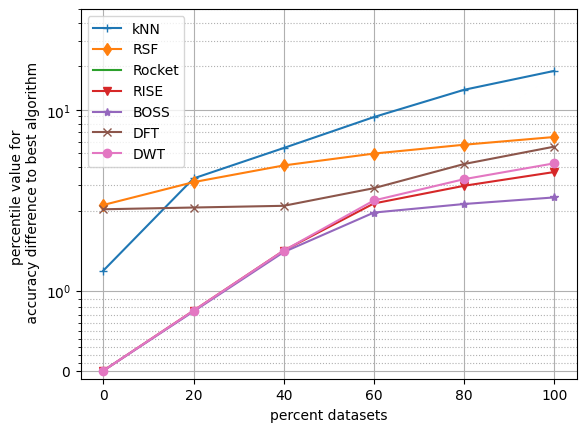

In [ ]:
perctiles = np.arange(0,1.2,.2)
perc_accuracy = diff_to_best.quantile(q=perctiles)
labels_xaxis = np.array(100*perctiles, dtype=int)

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(perctiles, perc_accuracy["kNN"], marker = "+", label="kNN")
ax.plot(perctiles, perc_accuracy["RSF"], marker = "d", label="RSF")
ax.plot(perctiles, perc_accuracy["Rocket"], marker = "", label="Rocket")
ax.plot(perctiles, perc_accuracy["RISE"], marker = "v", label="RISE")
ax.plot(perctiles, perc_accuracy["BOSS"], marker = "*", label="BOSS")
ax.plot(perctiles, perc_accuracy["DFT"], marker = "x", label="DFT")
ax.plot(perctiles, perc_accuracy["DWT"], marker = "o", label="DWT")


plt.xticks(perctiles, labels=labels_xaxis)
ax.set_ylim(-0.1,50)
ax.set_yscale('symlog')
ax.yaxis.set_minor_locator(tck.SymmetricalLogLocator(base=10, linthresh=.1, subs=np.arange(1, 10)))

ax.set_ylabel('percentile value for \n accuracy difference to best algorithm')
ax.set_xlabel('percent datasets')

ax.legend(loc=2)
ax.grid(which="major")
ax.grid(which="minor", ls=":")
plt.savefig("figures/fig2a.pdf", dpi=100, bbox_inches="tight", format="pdf")

FileNotFoundError: [Errno 2] No such file or directory: 'figures/fig2b.pdf'

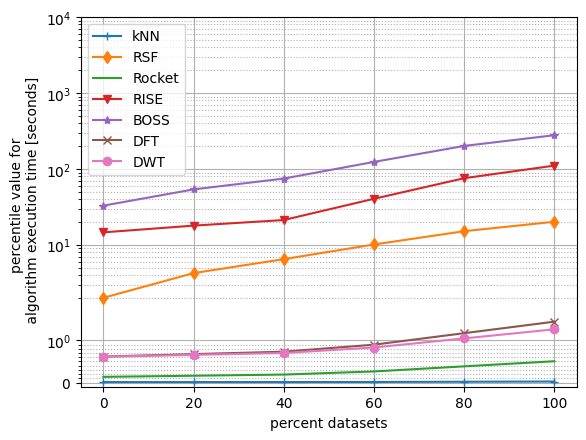

In [ ]:
perctiles = np.arange(0,1.2,.2)

perc_complexity = complexities_mean.quantile(q=perctiles)
labels_xaxis = np.array(100*perctiles, dtype=int)


fig = plt.figure()
ax = fig.add_subplot()
ax.plot(perctiles, perc_complexity["kNN"], marker = "+", label="kNN")
ax.plot(perctiles, perc_complexity["RSF"], marker = "d", label="RSF")
ax.plot(perctiles, perc_complexity["Rocket"], marker = "", label="Rocket")
ax.plot(perctiles, perc_complexity["RISE"], marker = "v", label="RISE")
ax.plot(perctiles, perc_complexity["BOSS"], marker = "*", label="BOSS")
ax.plot(perctiles, perc_complexity["DFT"], marker = "x", label="DFT")
ax.plot(perctiles, perc_complexity["DWT"], marker = "o", label="DWT")

ax.set_ylabel('percentile value for \n algorithm execution time [seconds]')
ax.set_xlabel('percent datasets')
plt.xticks(perctiles, labels=labels_xaxis)
ax.set_ylim(-0.1,10000)
ax.set_yscale('symlog')
ax.yaxis.set_minor_locator(tck.SymmetricalLogLocator(base=10, linthresh=.1, subs=np.arange(1, 10)))

ax.legend(loc=2)
ax.grid(which="major")
ax.grid(which="minor", ls=":")
plt.savefig("figures/fig2b.pdf", dpi=100, bbox_inches="tight", format="pdf")